<h1>Tundmusanalüüs ja teemade analüüs</h1>

<h3>Vajalikud <i>import</i>-id</h3>

In [32]:
import nltk
import os, os.path
import json
import re
import matplotlib.pyplot as plt
import pandas as pd
import random
import math
import numpy as np

from bertopic import BERTopic
from hdbscan import HDBSCAN
from bertopic.representation import KeyBERTInspired
from tqdm import tqdm
from estnltk import Text
from collections import Counter
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA
from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import CountVectorizer
from bertopic.vectorizers import ClassTfidfTransformer
from umap import UMAP
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from datetime import datetime
from collections import defaultdict

<h5>Loeme sisse stopp-sõnad</h5>

In [2]:
with open('estonian-stopwords.txt', encoding='utf-8') as f:
    stop_words_est = [word for line in f for word in line.split()]

In [3]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\taunotam\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

<h3>Loeme andmed sisse</h3>

In [4]:
path = 'data_lang/'
data = []

for file in os.listdir(path):
    filename = os.path.join(path, file)
    with open(filename, "r", encoding = 'utf-8') as fin:
        data.append(json.loads(fin.read()))

In [5]:
len(data)

44099

In [6]:
#print(data[320]["text"])

for post in data[:32]:
    if not isinstance(post["comments"], list):
        for com in post["comments"].values():
            if "removed" in com["text"]:
                print(com["text"])

<h3>Tundmusanalüüs - ET</h3>

<h5>Otsime välja kõik eestikeelsed tekst-tüüpi postitused ning nende kommentaarid ning puhastame andmed.</h5>

In [49]:
texts_et = {'text':[], 
        'time':[], 
        'sentiment':[],
        'comment_text':[],
        'comment_sentiment':[]
       }

texts_et_under50 = []
texts_et_over100 = []
texts_tühjad = []
texts_prügi = []
pealkirjad = []
ET_counter = 0

for post in data:
    if "lang" in post["meta"].keys():
        lang = post["meta"]["lang"]

        if lang == "ET":
            ET_counter += 1
            text = post["text"]
            text = text.replace('[deleted]', ' ')
            text = text.replace('[deleted by user]', ' ')
            text = text.replace('[removed]', ' ')
            text = text.replace('\n', ' ')
            text = text.replace('#x200B;', '')
            text = text.replace('\xa0', ' ')
            text = text.replace('&amp;', '&')
            text = re.sub(r'https?:\S+|www\.\S+|&#x200B;', ' ', text)
            text = text.strip()
            pikkus = len(text)
            if text != " [" and text != "[" and text != "." and text != '&' and text != '' and pikkus >= 50:
                text = post["meta"]["title"] + " " + text
                
                if len(text) >= 50:
                    texts_et["text"].append(text)
                    texts_et["time"].append(post["meta"]["created_utc"])

                    puh_com_list = []
                    if not isinstance(post["comments"], list):
                        comment_list = post["comments"].values()

                        for com_text in comment_list:
                            comment_text = com_text["text"]
                            if comment_text != "[deleted]" and comment_text != "[removed]":
                                comment_text = comment_text.replace('\n', ' ')
                                comment_text = comment_text.replace('#x200B;', '')
                                comment_text = comment_text.replace('\xa0', ' ')
                                comment_text = comment_text.replace('&amp;', '&')
                                comment_text = re.sub(r'https?:\S+|www\.\S+|&#x200B;', ' ', comment_text)
                                comment_text = comment_text.strip()
                                puh_com_list.append(comment_text)

                    texts_et["comment_text"].append(puh_com_list)
            
                
print("Eestikeelseid postitusi oli", ET_counter)

Eestikeelseid postitusi oli 10012


In [39]:
def average_item_length(lst):
    total_length = 0
    for item in lst:
        total_length += len(item)
    if len(lst) > 0:
        return total_length / len(lst)
    else:
        return 0

print("Average length:", average_item_length(pealkirjad))

Average length: 42.34318817419097


In [61]:
len(texts_et["text"])

6071

In [62]:
len(texts_et_over100)

5318

In [63]:
len(pealkirjad)

10012

In [64]:
len(texts_prügi)

158

In [65]:
len(texts_tühjad)

3351

In [71]:
len(texts_et_under50)

590

<h5>Omistame tundmuse sildid postitustele</h5>

In [50]:
tokenizer = AutoTokenizer.from_pretrained("EMBEDDIA/est-roberta")
model = AutoModelForSequenceClassification.from_pretrained("roBertaSentiment/",local_files_only=True)

max_length = 512
tokenizer.model_max_length = max_length

sentiment_analysis = pipeline(task="sentiment-analysis", model=model, tokenizer=tokenizer)

for text in tqdm(texts_et["text"]):
    sisu = text[:max_length]
    result = sentiment_analysis(sisu)[0]
    texts_et["sentiment"].append(result["label"])


100%|██████████████████████████████████████████████████████████████████████████████| 6071/6071 [17:45<00:00,  5.70it/s]


<h5>Omistame tundmuse sildid kommentaaridele</h5>

In [51]:
for com_list in tqdm(texts_et["comment_text"]):
    sents = []
    for text in com_list:
        sisu = text[:max_length]
        result = sentiment_analysis(sisu)[0]
        sents.append(result["label"])
    texts_et["comment_sentiment"].append(sents)

100%|████████████████████████████████████████████████████████████████████████████| 6071/6071 [4:35:04<00:00,  2.72s/it]


In [52]:
print(len(texts_et["text"]))
print(len(texts_et["time"]))
print(len(texts_et["sentiment"]))
print(len(texts_et["comment_text"]))
print(len(texts_et["comment_sentiment"]))

6071
6071
6071
6071
6071


<h5>Salvestame vahetulemused</h5>

In [53]:
df_to_save = pd.DataFrame.from_dict(texts_et)
df_to_save.to_csv('all_sentiment.csv', index=False)

In [215]:
df_et = pd.read_csv('all_sentiment.csv')

<h3>Tundmuse jaotuvus - ET</h3>
<h5>Loome tundmuse jaotuvuse joonised postitustele ja kommentaaridele</h5>

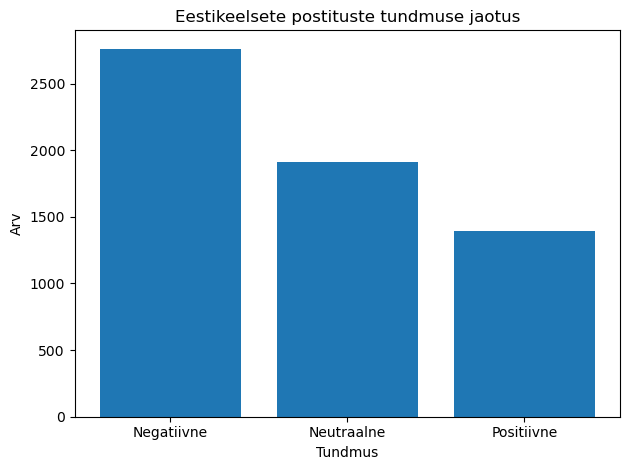

In [69]:
counts = Counter(texts_et["sentiment"])

categories = list(counts.keys())
counts_values = list(counts.values())

sorted_categories = sorted(categories)
sorted_counts_values = [counts[cat] for cat in sorted_categories]

plt.bar(sorted_categories, sorted_counts_values)

plt.xlabel('Tundmus')
plt.ylabel('Arv')
plt.title("Eestikeelsete postituste tundmuse jaotus")

plt.xticks([0, 1, 2], ['Negatiivne', 'Neutraalne', 'Positiivne'])
plt.tight_layout()
plt.show()

In [65]:
com_sentiment_concat = [j for i in texts_et["comment_sentiment"] for j in i]

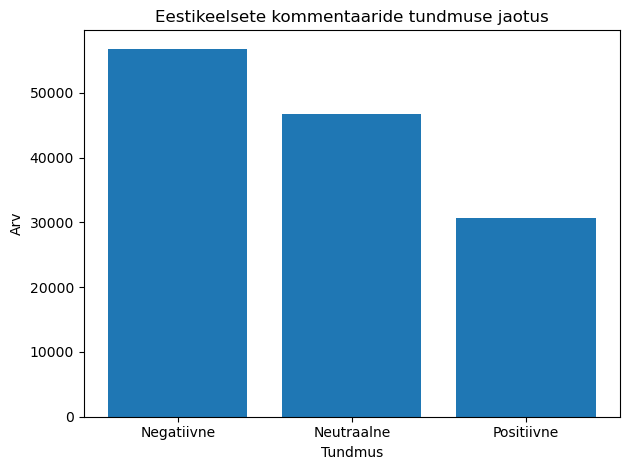

In [70]:
counts = Counter(com_sentiment_concat)

categories = list(counts.keys())
counts_values = list(counts.values())

sorted_categories = sorted(categories)
sorted_counts_values = [counts[cat] for cat in sorted_categories]

plt.bar(sorted_categories, sorted_counts_values)

plt.xlabel('Tundmus')
plt.ylabel('Arv')
plt.title("Eestikeelsete kommentaaride tundmuse jaotus")

plt.xticks([0, 1, 2], ['Negatiivne', 'Neutraalne', 'Positiivne'])
plt.tight_layout()
plt.show()

<h5>Vaatame, kas ja kuidas on postituste tundmus muutunud ajas</h5>

In [71]:
stacked_dict_sentiment = dict()
stacked_dict_sentiment["label"] = []
stacked_dict_sentiment["year"] = []

texts_et_ajad = texts_et["time"]

for i in range(len(texts_et["sentiment"])):
    label = texts_et["sentiment"][i]
    if texts_et_ajad[i][:4] != "2023":
        stacked_dict_sentiment["label"].append(label)
        stacked_dict_sentiment["year"].append(texts_et_ajad[i][:4])

In [72]:
cross_tab_prop = pd.crosstab(index=stacked_dict_sentiment['year'],
                             columns=stacked_dict_sentiment["label"],
                             normalize="index")

In [73]:
cross_tab_prop.plot(kind='bar', 
                    stacked=True, 
                    colormap='tab10', 
                    figsize=(10, 6))

plt.legend(loc="upper left", ncol=2)
plt.xlabel("Aasta")
plt.ylabel("Proportsioon")
plt.title("Tundmuste proportsioon eestikeelsel tekstil läbi aastate")
plt.show()

<h3>Teemade analüüs - ET</h3>

In [435]:
df_et = pd.DataFrame(texts_et)

<h5>Lemmatiseerime teksti</h5>

In [216]:
lemma_texts = []

for i in tqdm(list(df_et.text)):
    text = i
    text = re.sub(r'[^\w\s]', '', text)
    text = Text(text)
    lemma_list = list(text.tag_layer().lemma)
    flat_lemmas = [lemma for sublist in lemma_list for lemma in sublist]
    
    sentence = ' '.join(flat_lemmas)
    lemma_texts.append(sentence)

100%|██████████████████████████████████████████████████████████████████████████████| 6071/6071 [03:38<00:00, 27.72it/s]


In [217]:
df_et['text_lemma'] = lemma_texts
#df_et

<h5>Täiendame stopp-sõnade listi</h5>

In [189]:
stop_words_est += ['mina', 'tema', 'sina', 'olema', 'kui', 'ja', 'see', 'ei', 'et', 'mis', 'aga', 'ei', 'et', 'ja', 'jah', 'kas', 'kui', 'kõik', 'ma', 'me', 'mida', 'midagi',
'mind', 'minu', 'mis', 'mu', 'mul', 'mulle', 'nad', 'nii', 'oled', 'olen', 'oli', 'oma', 'on', 'pole', 'sa', 'seda', 'see', 'selle', 'siin', 'siis', 'ta', 'te', 'ära']

<h5>BERTopic-u ja sellega seotud mudelite initseerimine</h5>
<p>Dokumentatsioon: <a href="https://maartengr.github.io/BERTopic/index.html">https://maartengr.github.io/BERTopic/index.html</a></p>

In [191]:
vectorizer_model = CountVectorizer(stop_words=stop_words_est)

ctfidf_model = ClassTfidfTransformer(reduce_frequent_words=True)

umap_model = UMAP(angular_rp_forest=True, low_memory=False, metric='cosine', min_dist=0.0, n_components=5, random_state = 42, n_neighbors=15)

representation_model = KeyBERTInspired()

In [192]:
hdbscan_model = HDBSCAN(min_cluster_size=20, metric='euclidean', cluster_selection_method='eom', prediction_data=True)

In [193]:
bert_topic_model = BERTopic(language="Estonian",
                            vectorizer_model=vectorizer_model,
                            ctfidf_model=ctfidf_model,
                            umap_model = umap_model,
                            hdbscan_model=hdbscan_model,
                            calculate_probabilities = True, 
                            verbose = True,
                            representation_model=representation_model
                           )
topics, probabilities = bert_topic_model.fit_transform(list(df_et.text_lemma))

2024-04-29 10:50:57,164 - BERTopic - Embedding - Transforming documents to embeddings.


INFO:SentenceTransformer.py:107: Load pretrained SentenceTransformer: sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2
INFO:SentenceTransformer.py:213: Use pytorch device_name: cpu


Batches: 100%|███████████████████████████████████████████████████████████████████████| 190/190 [05:44<00:00,  1.81s/it]
2024-04-29 10:56:45,897 - BERTopic - Embedding - Completed ✓
2024-04-29 10:56:45,898 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-04-29 10:56:59,444 - BERTopic - Dimensionality - Completed ✓
2024-04-29 10:56:59,446 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-04-29 10:57:00,403 - BERTopic - Cluster - Completed ✓
2024-04-29 10:57:00,409 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-04-29 10:57:35,262 - BERTopic - Representation - Completed ✓


<h5>Vähendame piirjuhtude hulka</h5>

In [194]:
new_topics = bert_topic_model.reduce_outliers(list(df_et.text_lemma), topics, strategy="c-tf-idf", threshold=0.02)

In [195]:
bert_topic_model.update_topics(list(df_et.text_lemma), topics=new_topics, vectorizer_model=vectorizer_model)

2024-04-29 10:57:36,083 - BERTopic - WARNING: Using a custom list of topic assignments may lead to errors if topic reduction techniques are used afterwards. Make sure that manually assigning topics is the last step in the pipeline.Note that topic embeddings will also be created through weightedc-TF-IDF embeddings instead of centroid embeddings.


In [196]:
bert_df = bert_topic_model.get_topic_info()

counter_topic = 0
for i in range(len(bert_df)):
    print(bert_df.loc[i, "Topic"], "|", bert_df.loc[i, "Count"], "|", bert_df.loc[i, "Representation"])
    counter_topic += bert_df.loc[i, "Count"]

print(counter_topic)

-1 | 33 | ['grenade', 'grena', 'bayern', 'münchen', 'värvitud', 'jalanôu', 'väljakujunenud', 'pipi', 'sisestatud', 'pip']
0 | 326 | ['venemaa', 'ukraina', 'vene', 'eesti', 'sõda', 'venelane', 'riik', 'keel', 'nõukogu', 'euroopa']
1 | 354 | ['ülikool', 'õppima', 'kool', 'eriala', 'it', 'matemaatika', 'gümnaasium', 'tartu', 'kogemus', 'aasta']
2 | 207 | ['laul', 'muusika', 'lugu', 'kuulama', 'raadio', 'lood', 'loog', 'eesti', 'album', 'bänd']
3 | 237 | ['telia', 'internet', 'telefon', 'pakett', 'elisa', 'kasutama', 'vaatama', 'ruuter', 'net', 'kogemus']
4 | 251 | ['ekre', 'erakond', 'riigikogu', 'valimine', 'isamaa', 'eesti', 'valitsus', 'gt', 'keskerakond', 'riik']
5 | 213 | ['the', 'keel', 'to', 'and', 'of', 'in', 'eesti', 'elleruu', 'for', 'estonian']
6 | 235 | ['artikkel', 'postitus', 'postimees', 'reddit', 'redditi', 'uus', 'inimene', 'kasutaja', 'reesti', 'pilt']
7 | 213 | ['ajateenistus', 'kaitsevägi', 'arstlik', 'komisjon', 'käinud', 'küsimus', 'trahv', 'kutse', 'nimetatud', 'aeg

<h5>Vaadates sõnaesitusi ning kategooriatesse määratud tekste, paneme klastritele nimed</h5>

In [208]:
topic_labels_et = ["Ukraina sõda", "Haridus", "Muusika", "Telekommunikatsioon", "Poliitika", "Keel ja tõlge", "Infovahetus", "Kaitsevägi", "COVID-19", "Mängimine (gaming)", "Toit", 
                   "Kohad Tallinnas", "Varia",
                   "Tervishoid", "Juhiload", "Ühistransport", "Ostma/müüma", "Video", "Energiaallikas", "Töötamine", "Kohad", "Finants", "Rahvus", "Tähtpäevad", "Filmid ja sarjad","Kohad", "Arvuti", "Kinnisvara", 
                   "Ostlemine veebis", "Juriidika", "Auto ostmine", "Kuller- ja taksoteenus", "Varia", "Film ja sarjad", "Hambaravi", "Elektroonika", "Suitsetamine", "Küsitlus", 
                   "Pension", "Autokool", "Lennundus", "Maski kandmine",
                   "Vaimne tervis", "Telesaade", "Ostlemine veebis"
                    ]

<h5>Visualiseerime top 30 teemat läbi aja (joonis on interaktiivne)</h5>

In [209]:
topics_over_time = bert_topic_model.topics_over_time(list(df_et.text_lemma), list(df_et.time), nr_bins=100)

100it [00:13,  7.16it/s]


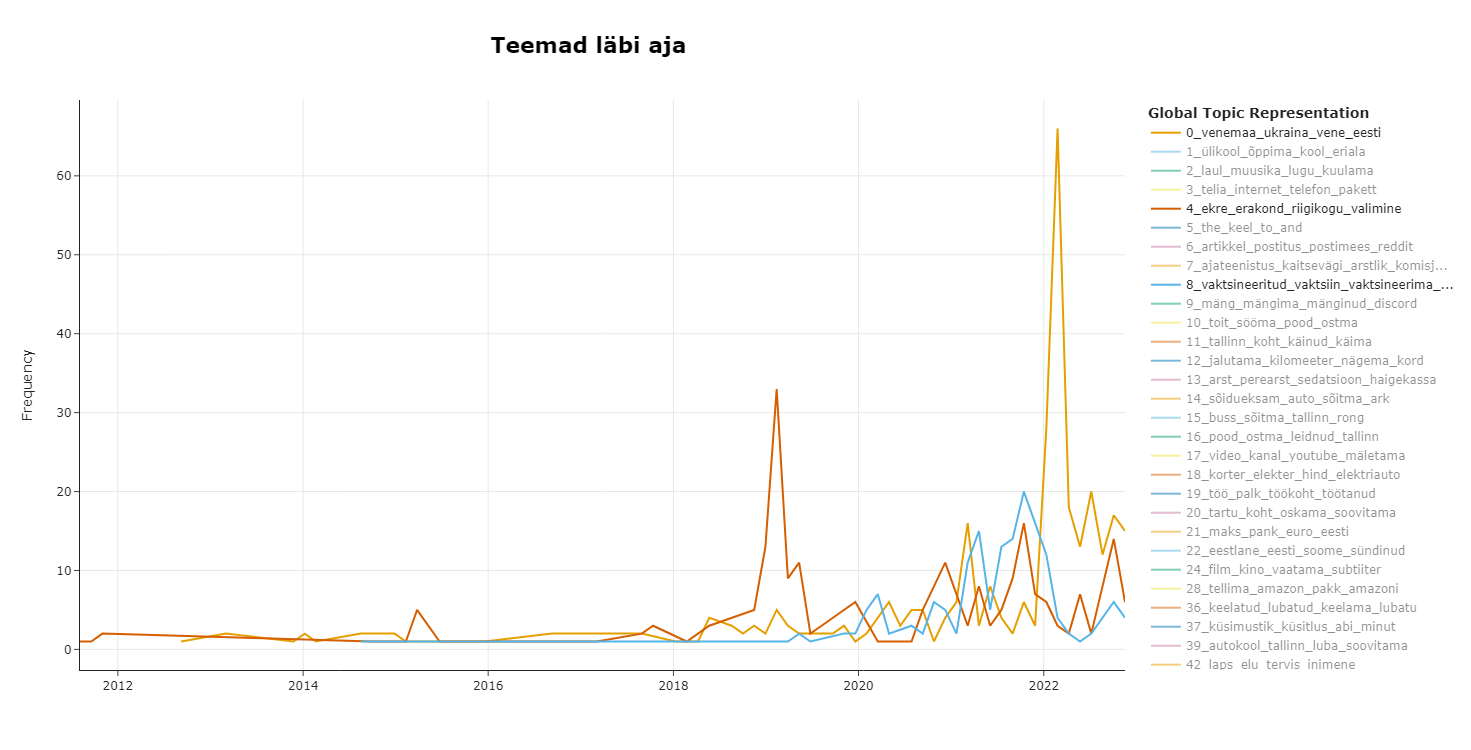

In [210]:
bert_topic_model.visualize_topics_over_time(topics_over_time, top_n_topics=30, title="<b>Teemad läbi aja</b>", height=750, custom_labels=True)

<h5>Lisame uued teemade sildid koos teemadega andmestikku ning vaatame postituste ja kommentaaride tundmust üle teemade</h5>

In [218]:
teemad = bert_topic_model.get_document_info(df_et["text_lemma"])['Topic']
df_et['topic'] = teemad
df_et['topic_name'] = bert_topic_model.get_document_info(df_et["text_lemma"])['Name']
df_et['topic_labels'] = df_et['topic'].replace([i for i in range(45)], topic_labels_et)

In [228]:
df_et = df_et[df_et['topic'] != -1]

df_et = df_et.reset_index(drop=True)

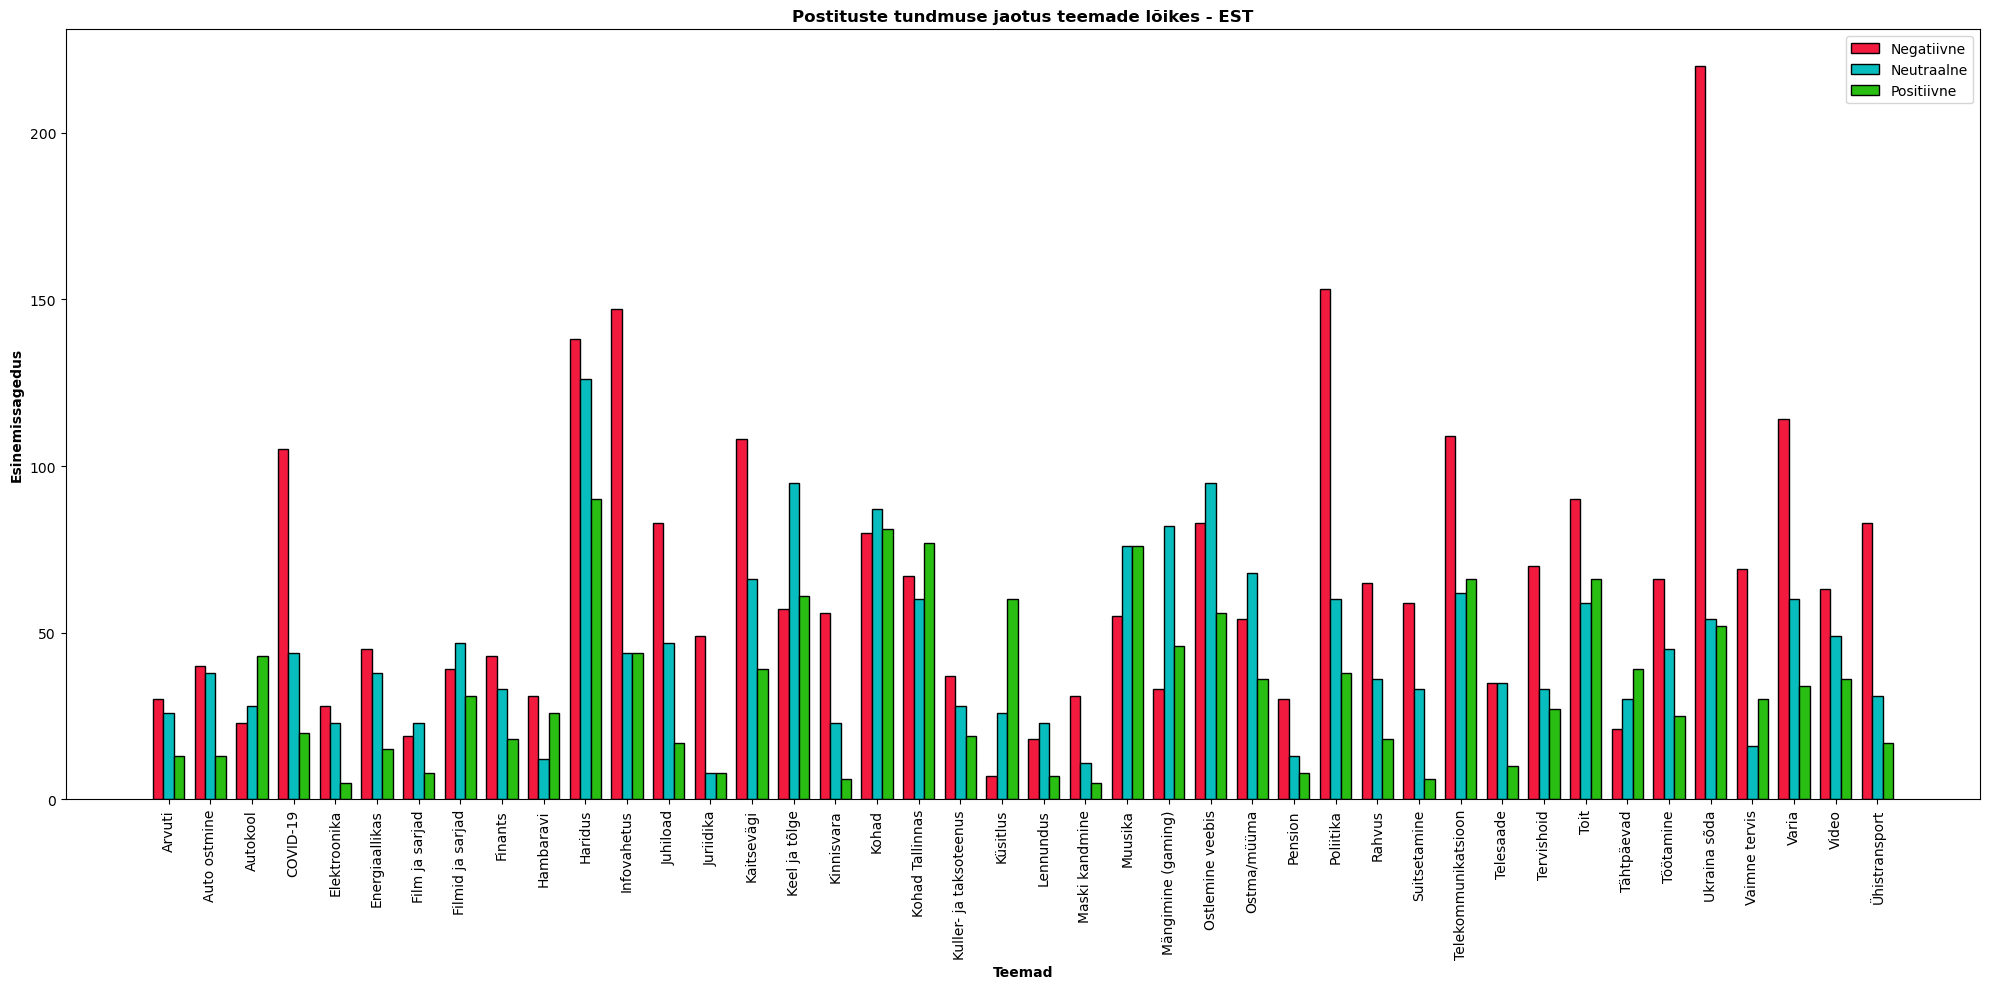

In [308]:
grouped = df_et.groupby('topic_labels')

negative_counts = []
neutral_counts = []
positive_counts = []
topics = []

for name, group in grouped:
    topics.append(name)
    sentiment_counts = group['sentiment'].value_counts()
    negative_counts.append(sentiment_counts.get('Negatiivne', 0))
    neutral_counts.append(sentiment_counts.get('Neutraalne', 0))
    positive_counts.append(sentiment_counts.get('Positiivne', 0))

bar_width = 0.25

r1 = np.arange(len(topics))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]

plt.figure(figsize=(20, 10))

plt.bar(r1, negative_counts, color='#f21b3f', edgecolor='black', width=bar_width, label='Negatiivne')
plt.bar(r2, neutral_counts, color='#08bdbd', edgecolor='black', width=bar_width, label='Neutraalne')
plt.bar(r3, positive_counts, color='#29bf12', edgecolor='black', width=bar_width, label='Positiivne')

plt.xlabel('Teemad', fontweight='bold')
plt.xticks([r + bar_width for r in range(len(topics))], topics)

plt.ylabel('Esinemissagedus', fontweight='bold')
plt.title('Postituste tundmuse jaotus teemade lõikes - EST', fontweight='bold')

plt.legend()

plt.xticks(rotation=90)
plt.savefig('topic_post_et.png')
plt.tight_layout()
plt.show()


In [302]:
topic_com_labels = dict()

for i in range(len(df_et)):
    topic = df_et.loc[i].topic_labels
    str = df_et.loc[i]["comment_sentiment"]
    res = str.replace("'", "")
    res = res.strip('][').split(', ')

    if topic not in topic_com_labels.keys():
        topic_com_labels[topic] = res

    else:
        for j in res:
            if isinstance(j, list):
                for k in j:
                    topic_com_labels[topic].append(k)
            else:
                topic_com_labels[topic].append(j)

In [ ]:
sent_dict = dict()
topic_com_labels = dict()

for i in range(len(df_et)):
    topic = df_et.loc[i].topic_labels
    
    if topic not in sent_dict.keys():
        sent_dict[topic] = [[df_et.loc[i]["sentiment"], df_et.loc[i]["comment_sentiment"]]]

        i_topic_list = []
        for j in df_et.loc[i]["comment_sentiment"]:
            if isinstance(j, list):
                for k in j:
                    i_topic_list.append(k)
            else:
                i_topic_list.append(j)

        topic_com_labels[topic] = i_topic_list

    else:
        sent_dict[topic].append([df_et.loc[i]["sentiment"], df_et.loc[i]["comment_sentiment"]])

        for j in df_et.loc[i]["comment_sentiment"]:
            
            if isinstance(j, list):
                for k in j:
                    topic_com_labels[topic].append(k)
            else:
                topic_com_labels[topic].append(j)

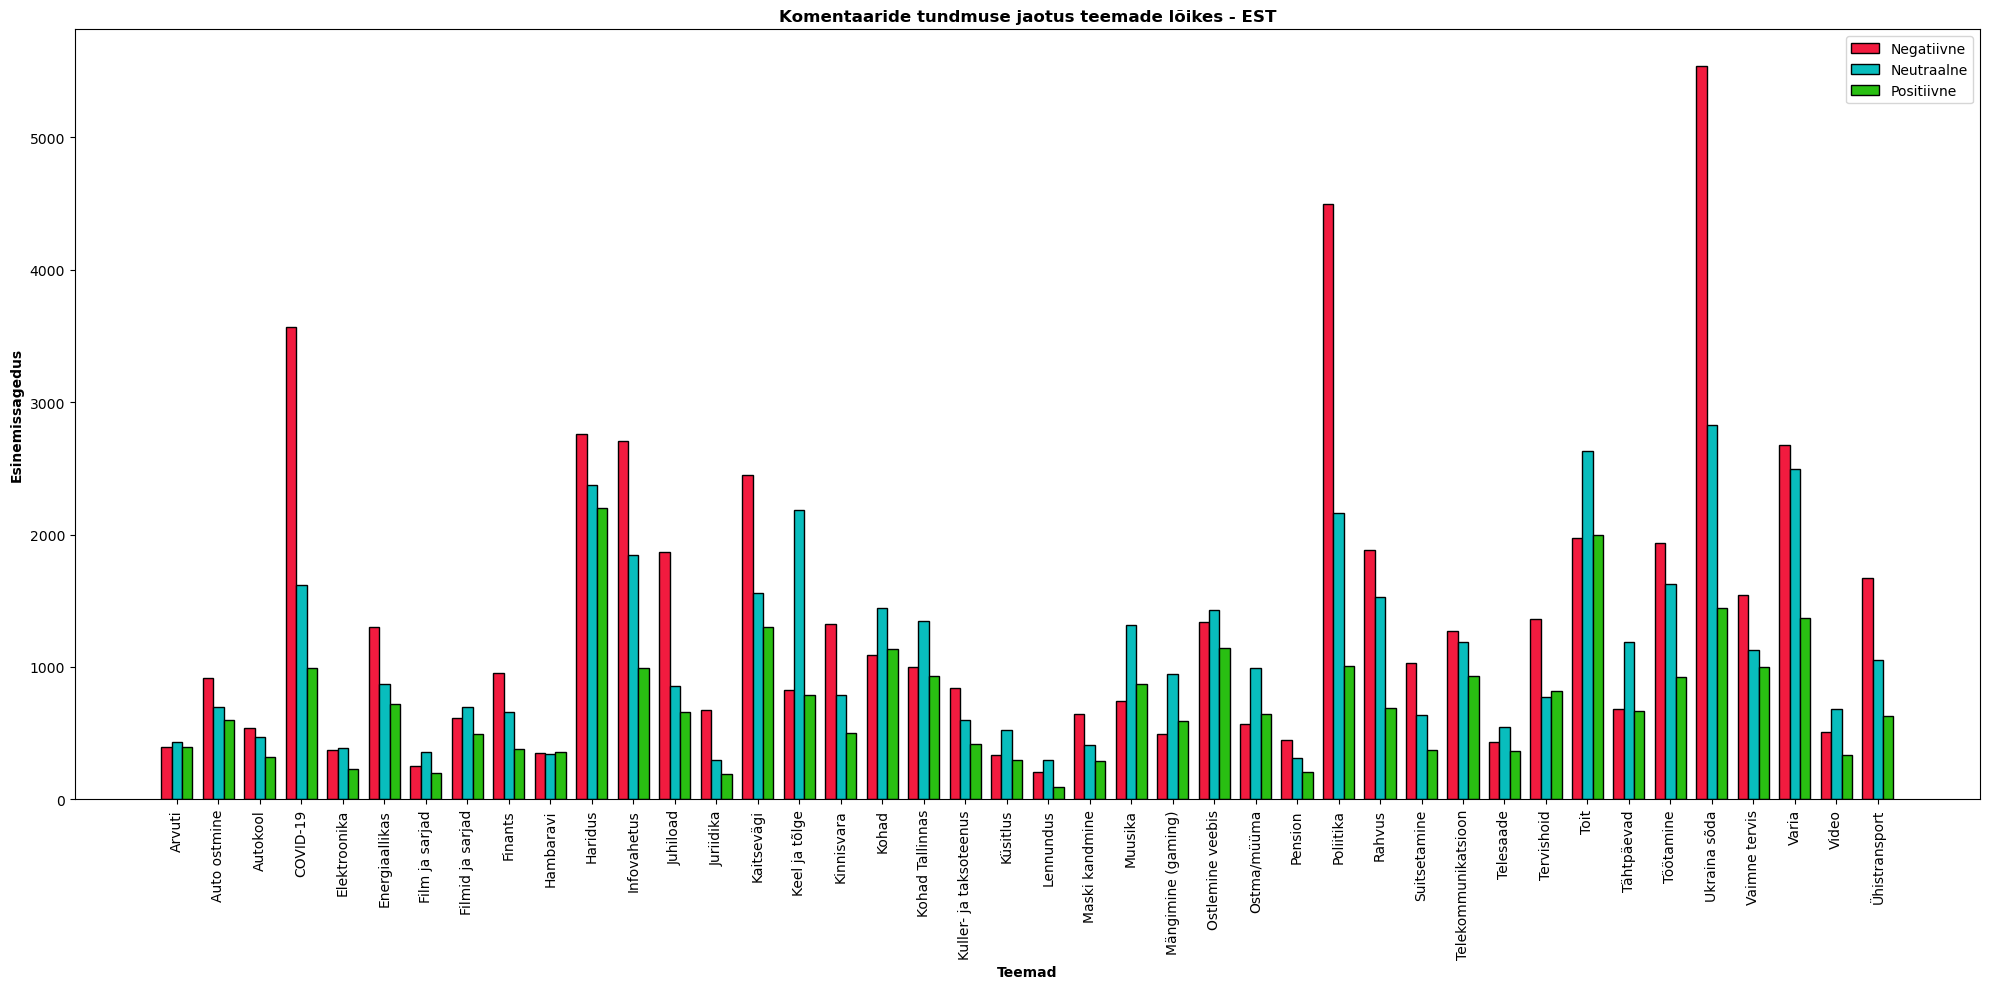

In [303]:
negative_counts = []
neutral_counts = []
positive_counts = []
topics = list(topic_com_labels.keys())
topics.sort()

for topic in topics:
    sentiment_counts = np.array([topic_com_labels[topic].count(label) for label in ['LABEL_0', 'LABEL_1', 'LABEL_2']])
    negative_counts.append(sentiment_counts[0])
    neutral_counts.append(sentiment_counts[1])
    positive_counts.append(sentiment_counts[2])

bar_width = 0.25

r1 = np.arange(len(topics))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]

plt.figure(figsize=(20, 10))

plt.bar(r1, negative_counts, color='#f21b3f', edgecolor='black', width=bar_width, label='Negatiivne')
plt.bar(r2, neutral_counts, color='#08bdbd', edgecolor='black', width=bar_width, label='Neutraalne')
plt.bar(r3, positive_counts, color='#29bf12', edgecolor='black', width=bar_width, label='Positiivne')

plt.xlabel('Teemad', fontweight='bold')
plt.xticks([r + bar_width for r in range(len(topics))], topics)
plt.ylabel('Esinemissagedus', fontweight='bold')
plt.title('Komentaaride tundmuse jaotus teemade lõikes - EST', fontweight='bold')
plt.legend()
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

<h5>Otsime üles iga aasta kõige populaarsema teema</h5>

In [275]:
df_et['year'] = [datetime.strptime(dt, '%Y-%m-%d %H:%M:%S').year for dt in df_et['time']]
df_et['sentiment'] = df_et['sentiment'].replace(["LABEL_0", "LABEL_1", "LABEL_2"], ["Negatiivne", "Neutraalne", "Positiivne"])

In [276]:
df_topics_et = pd.DataFrame({'Year': list(df_et['year']), 'Topic': list(df_et['topic_labels'])})

most_popular_topics = df_topics_et.groupby('Year')['Topic'].agg(lambda x: x.mode()[0])

df_most_popular = pd.DataFrame({'Year': most_popular_topics.index, 'Most Popular Topic': most_popular_topics.values})

print(df_most_popular)

    Year   Most Popular Topic
0   2010              Haridus
1   2011          Infovahetus
2   2012        Keel ja tõlge
3   2013        Keel ja tõlge
4   2014        Keel ja tõlge
5   2015                Kohad
6   2016  Telekommunikatsioon
7   2017              Haridus
8   2018                Kohad
9   2019            Poliitika
10  2020              Haridus
11  2021             COVID-19
12  2022         Ukraina sõda


<h5>Viime eelnevad "Postituste ja kommentaaride tundmused üle teemade" joonised loetavamale kujule, st. näitame vaid 10 kõige populaarsemat teemat.</h5> 

In [289]:
frequent_topics = df_et[(df_et['topic'] < 10)]
frequent_topics = frequent_topics.reset_index(drop=True)

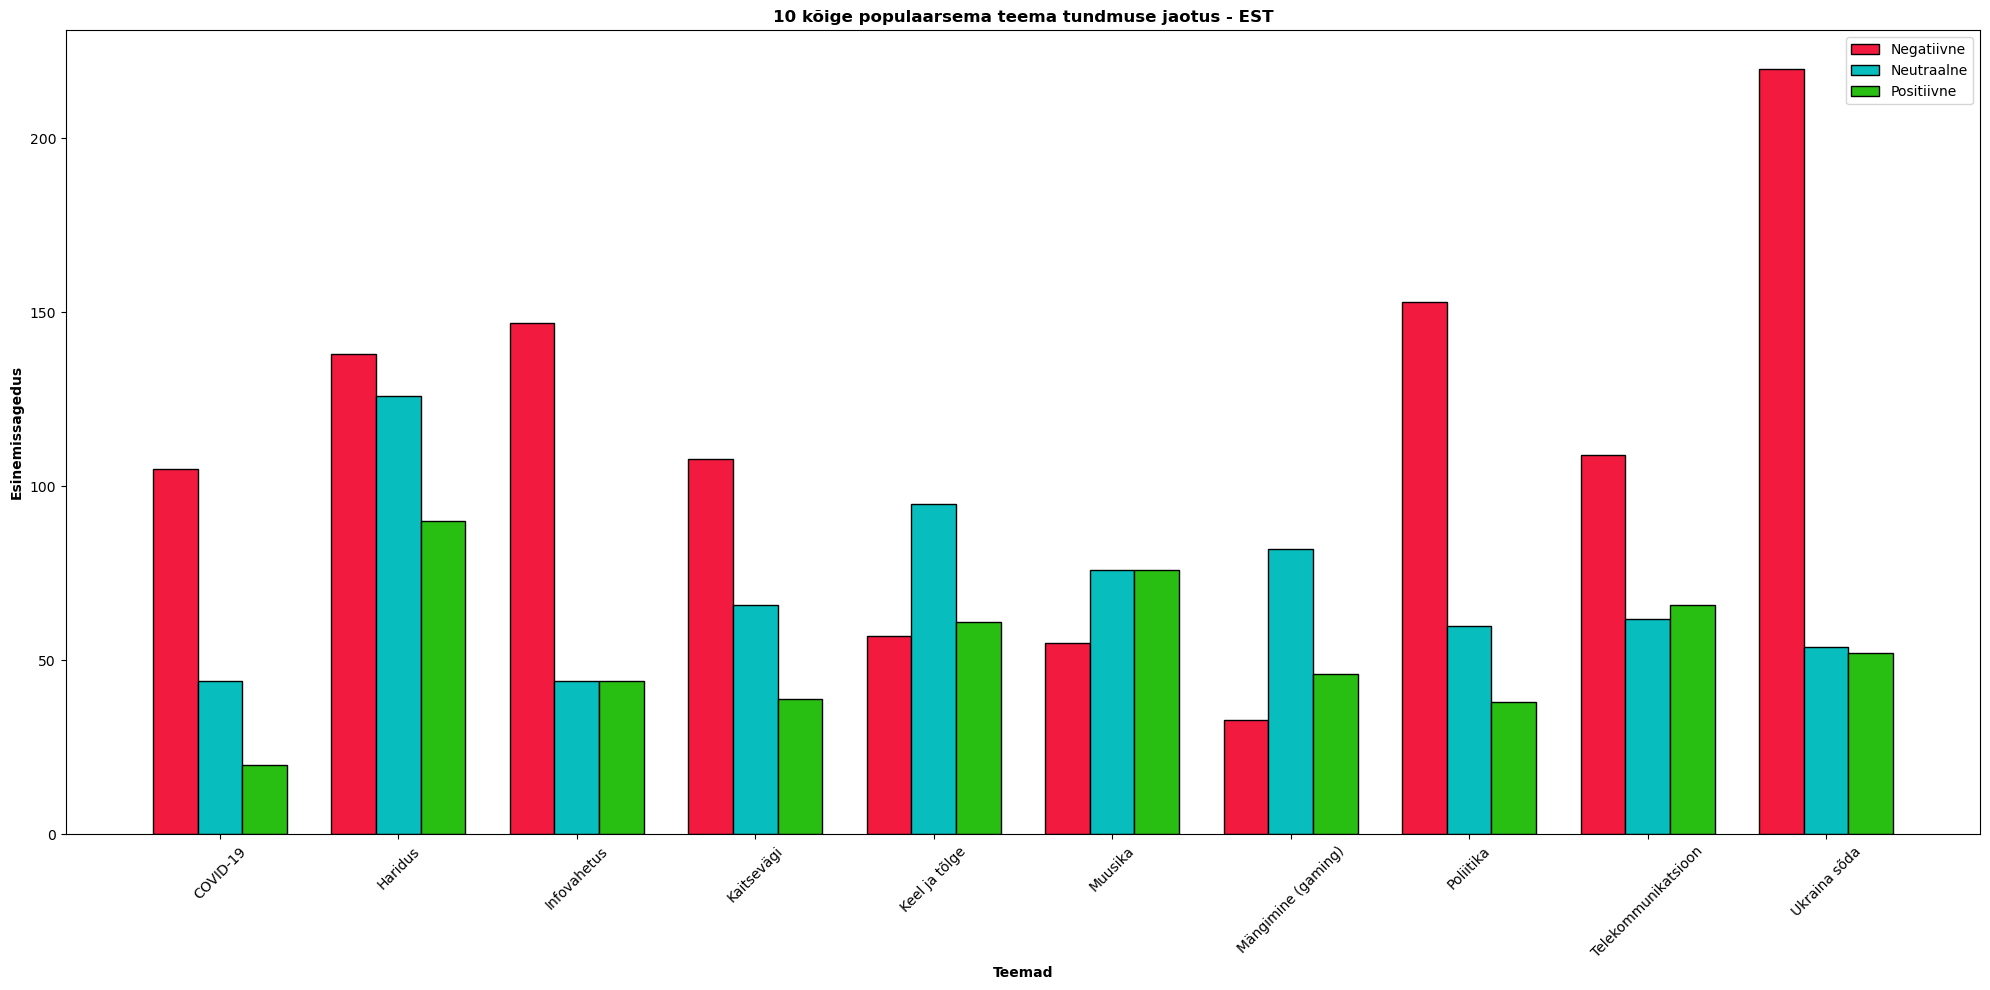

In [296]:
grouped = frequent_topics.groupby('topic_labels')

negative_counts = []
neutral_counts = []
positive_counts = []
topics = []

for name, group in grouped:
    topics.append(name)
    sentiment_counts = group['sentiment'].value_counts()
    negative_counts.append(sentiment_counts.get('Negatiivne', 0))
    neutral_counts.append(sentiment_counts.get('Neutraalne', 0))
    positive_counts.append(sentiment_counts.get('Positiivne', 0))

bar_width = 0.25

r1 = np.arange(len(topics))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]

plt.figure(figsize=(20, 10))

plt.bar(r1, negative_counts, color='#f21b3f', edgecolor='black', width=bar_width, label='Negatiivne')
plt.bar(r2, neutral_counts, color='#08bdbd', edgecolor='black', width=bar_width, label='Neutraalne')
plt.bar(r3, positive_counts, color='#29bf12', edgecolor='black', width=bar_width, label='Positiivne')

plt.xlabel('Teemad', fontweight='bold')
plt.xticks([r + bar_width for r in range(len(topics))], topics)

plt.ylabel('Esinemissagedus', fontweight='bold')
plt.title('10 kõige populaarsema teema tundmuse jaotus - EST', fontweight='bold')

plt.legend()

plt.xticks(rotation=45)
plt.savefig('topic_post_et.png')
plt.tight_layout()
plt.show()


In [291]:
topic_com_labels = dict()

for i in range(len(frequent_topics)):
    topic = frequent_topics.loc[i].topic_labels
    str = frequent_topics.loc[i]["comment_sentiment"]
    res = str.replace("'", "")
    res = res.strip('][').split(', ')

    if topic not in topic_com_labels.keys():
        topic_com_labels[topic] = res

    else:
        for j in res:
            if isinstance(j, list):
                for k in j:
                    topic_com_labels[topic].append(k)
            else:
                topic_com_labels[topic].append(j)

In [295]:
negative_counts = []
neutral_counts = []
positive_counts = []
topics = list(topic_com_labels.keys())
topics.sort()

for topic in topics:
    sentiment_counts = np.array([topic_com_labels[topic].count(label) for label in ['LABEL_0', 'LABEL_1', 'LABEL_2']])
    negative_counts.append(sentiment_counts[0])
    neutral_counts.append(sentiment_counts[1])
    positive_counts.append(sentiment_counts[2])

bar_width = 0.25

r1 = np.arange(len(topics))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]

plt.figure(figsize=(20, 10))

plt.bar(r1, negative_counts, color='#f21b3f', edgecolor='black', width=bar_width, label='Negatiivne')
plt.bar(r2, neutral_counts, color='#08bdbd', edgecolor='black', width=bar_width, label='Neutraalne')
plt.bar(r3, positive_counts, color='#29bf12', edgecolor='black', width=bar_width, label='Positiivne')

plt.xlabel('Teemad', fontweight='bold')
plt.xticks([r + bar_width for r in range(len(topics))], topics)
plt.ylabel('Esinemissagedus', fontweight='bold')
plt.title('Komentaaride tundmuse jaotus 10 kõige populaarsema teema suhtes - ET', fontweight='bold')
plt.legend()
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig('topic_com_et.png')
plt.show()

In [235]:
df_et.to_csv('topics_n_sents_et_out.csv', index=False) 

<h3>Tundmusanalüüs - EN</h3>

<h5>Otsime välja kõik ingliskeelsed tekst-tüüpi postitused ning nende kommentaarid ning puhastame andmed.</h5>

In [7]:
texts_en = {'text':[], 
        'time':[], 
        'sentiment':[],
        'comment_text':[],
        'comment_sentiment':[]
       } 

texts_en_under50 = []
texts_en_over100 = []
texts_en_tühjad = []
texts_en_prügi = []
pealkirjad_en = []
EN_counter = 0

for post in data:
    if "lang" in post["meta"].keys():
        lang = post["meta"]["lang"]

        if lang == "EN":
            text = post["text"]
            text = text.replace('[deleted]', ' ')
            text = text.replace('[deleted by user]', ' ')
            text = text.replace('[removed]', ' ')
            text = text.replace('\n', ' ')
            text = text.replace('#x200B;', '')
            text = text.replace('\xa0', ' ')
            text = text.replace('&amp;', '&')
            text = re.sub(r'https?:\S+|www\.\S+|&#x200B;', ' ', text)
            text = text.strip()
            pikkus = len(text)
            EN_counter += 1
            #if text != " [" and text != "[" and text != "." and text != '&' and text != '' and pikkus >= 100:
            #    text = text + " " + post["meta"]["title"]
            #    texts_en["text"].append(text)
            #    texts_en["time"].append(post["meta"]["created_utc"])
            if text != " [" and text != "[" and text != "." and text != '&' and text != '' and pikkus >= 50:
                text = post["meta"]["title"] + " " + text

                if len(text) >= 50:
                    texts_en["text"].append(text)
                    texts_en["time"].append(post["meta"]["created_utc"])

                    puh_com_list = []
                    if not isinstance(post["comments"], list):
                        comment_list = post["comments"].values()

                        for com_text in comment_list:
                            comment_text = com_text["text"]
                            if comment_text != "[deleted]" and comment_text != "[removed]":
                                comment_text = comment_text.replace('\n', ' ')
                                comment_text = comment_text.replace('#x200B;', '')
                                comment_text = comment_text.replace('\xa0', ' ')
                                comment_text = comment_text.replace('&amp;', '&')
                                comment_text = re.sub(r'https?:\S+|www\.\S+|&#x200B;', ' ', comment_text)
                                comment_text = comment_text.strip()
                                puh_com_list.append(comment_text)

                    texts_en["comment_text"].append(puh_com_list)
                
print("Ingliskeelseid postitusi oli", EN_counter)

Ingliskeelseid postitusi oli 6581


In [8]:
len(texts_en["text"])

5003

In [9]:
len(texts_en_tühjad)

0

In [10]:
len(texts_en_prügi)

0

In [12]:
max_comment_len = 0
for com_list in texts_en["comment_text"]:
    for com_text in com_list:
        if len(com_text) > max_comment_len:
            max_comment_len = len(com_text)

In [13]:
max_comment_len

9957

<h5>Omistame tundmuse sildid postitustele</h5>

In [23]:
tokenizer = AutoTokenizer.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment-latest")
model = AutoModelForSequenceClassification.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment-latest")

max_length = 512
tokenizer.model_max_length = max_length

sentiment_analysis = pipeline(task="sentiment-analysis", model=model, tokenizer=tokenizer)

for text in tqdm(texts_en["text"]):
    sisu = text#[:max_length]
    
    len_sisu = len(sisu)
    if len_sisu > max_length:
        labels = []
        count = 0
        x_times = math.floor(len_sisu/max_length)
        for times in range(x_times):
            labels.append(sentiment_analysis(sisu[count:max_length])[0]['label'])
            count += max_length
    
        c = Counter(labels)
        result = c.most_common(1)[0][0]

    else:
        result = sentiment_analysis(sisu)[0]["label"]
    
    texts_en["sentiment"].append(result)

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████████████████████████████████████████████████████████████████████████| 5003/5003 [14:33<00:00,  5.73it/s]


<h5>Omistame tundmuse sildid kommentaaridele</h5>

In [114]:
tokenizer = AutoTokenizer.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment-latest")
model = AutoModelForSequenceClassification.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment-latest")

exception_counter = 0
max_length = 512#514
tokenizer.model_max_length = max_length

sentiment_analysis = pipeline(task="sentiment-analysis", model=model, tokenizer=tokenizer)

sentiment_en = []
file1 = open('eng_sent_out.txt', 'w', encoding="utf-8")
for com_list in tqdm(texts_en["comment_text"]):
    sents = []
    for text in com_list:
        sisu = text.replace('\n', '')
        if sisu != '' and sisu != ' ' and sisu != '[deleted]' and sisu != '[removed]':
            len_sisu = len(sisu)
            if len_sisu > max_length:
                file1.write(str(len_sisu) + "|" + sisu)
                file1.write("\n")
                labels = []
                count = 0
                x_times = math.floor(len_sisu/max_length)
                for times in range(x_times):
                    
                    try:
                        labels.append(sentiment_analysis(sisu[count:max_length])[0]['label'])
                    except:
                        labels.append("neutral")
                        exception_counter += 1
                    count += max_length

                try:
                    labels.append(sentiment_analysis(sisu[count:len_sisu])[0]['label'])
                except:
                    labels.append("neutral")
                    exception_counter += 1
    
                c = Counter(labels)
                result = c.most_common(1)[0][0]
    
            else:
                try:
                    result = sentiment_analysis(sisu)[0]['label']
                except:
                    result = "neutral"
                    exception_counter += 1
    
            sents.append(result)
            
    texts_en["comment_sentiment"].append(sents)

file1.close()

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|████████████████████████████████████████████████████████████████████████████| 5003/5003 [3:39:51<00:00,  2.64s/it]


In [137]:
#texts_en["comment_sentiment"]

In [111]:
exception_counter

2

In [15]:
exception_counter

73121

In [116]:
print(len(texts_en["text"]))
print(len(texts_en["time"]))
print(len(texts_en["sentiment"]))
print(len(texts_en["comment_text"]))
print(len(texts_en["comment_sentiment"]))

5003
5003
5003
5003
5003


In [117]:
df_to_save_en = pd.DataFrame.from_dict(texts_en)
df_to_save_en.to_csv('all_sentiment_EN.csv', index=False)

<h3>Tundmuse jaotuvus - EN</h3>
<h5>Loome tundmuse jaotuvuse joonised postitustele ja kommentaaridele</h5>

In [199]:
counts = Counter(texts_en["sentiment"])

categories = list(counts.keys())
counts_values = list(counts.values())

sorted_categories = sorted(categories)
sorted_counts_values = [counts[cat] for cat in sorted_categories]

# Create bar plot with sorted categories and counts_values
plt.bar(sorted_categories, sorted_counts_values)

plt.xlabel('Tundmus')
plt.ylabel('Arv')
plt.title('Ingliskeelsete postituste tundmuse jaotus')

plt.xticks([0, 1, 2], ['Negatiivne', 'Neutraalne', 'Positiivne'])
plt.tight_layout()
plt.show()

In [201]:
com_sentiment_concat_en = [j for i in texts_en["comment_sentiment"] for j in i]

In [202]:
counts = Counter(com_sentiment_concat_en)

categories = list(counts.keys())
counts_values = list(counts.values())

sorted_categories = sorted(categories)
sorted_counts_values = [counts[cat] for cat in sorted_categories]

# Create bar plot with sorted categories and counts_values
plt.bar(sorted_categories, sorted_counts_values)

plt.xlabel('Tundmus')
plt.ylabel('Arv')
plt.title("Ingliskeelsete kommentaaride tundmuse jaotus")

plt.xticks([0, 1, 2], ['Negatiivne', 'Neutraalne', 'Positiivne'])
plt.tight_layout()
plt.show()

<h3>Teemade analüüs - EN</h3>

In [27]:
df_en = pd.DataFrame(texts_en)

<h5>Lemmatiseerime teksti</h5>

In [28]:
lemma_texts = []
lemmatizer = WordNetLemmatizer()

for i in tqdm(list(df_en.text)):
    text = i
    text = re.sub(r'[^\w\s]', '', text)
    tokens = word_tokenize(text)
    sentence = ' '.join([lemmatizer.lemmatize(word) for word in tokens])
    lemma_texts.append(sentence)

100%|████████████████████████████████████████████████████████████████████████████| 5003/5003 [00:04<00:00, 1017.18it/s]


In [109]:
df_en['text_lemma'] = lemma_texts

<h5>BERTopic-u ja sellega seotud mudelite initseerimine</h5>
<p>Dokumentatsioon: <a href="https://maartengr.github.io/BERTopic/index.html">https://maartengr.github.io/BERTopic/index.html</a></p>

In [52]:
vectorizer_model = CountVectorizer(stop_words=stopwords.words('english'))

ctfidf_model = ClassTfidfTransformer(reduce_frequent_words=True)

umap_model = UMAP(angular_rp_forest=True, low_memory=False, metric='cosine', min_dist=0.0, n_components=5, random_state = 42, n_neighbors=15)

representation_model = KeyBERTInspired()

In [34]:
hdbscan_model = HDBSCAN(min_cluster_size=20, metric='euclidean', cluster_selection_method='eom', prediction_data=True)

In [54]:
bert_topic_model_en = BERTopic(language="English",
                            vectorizer_model=vectorizer_model,
                            ctfidf_model=ctfidf_model,
                            umap_model = umap_model,
                            hdbscan_model=hdbscan_model,
                            calculate_probabilities = True, 
                            verbose = True,
                            representation_model=representation_model
                           )
topics_en, probabilities_en = bert_topic_model_en.fit_transform(df_en["text_lemma"])

2024-04-28 13:28:56,046 - BERTopic - Embedding - Transforming documents to embeddings.


INFO:SentenceTransformer.py:107: Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2
INFO:SentenceTransformer.py:213: Use pytorch device_name: cpu


Batches: 100%|███████████████████████████████████████████████████████████████████████| 157/157 [05:16<00:00,  2.02s/it]
2024-04-28 13:34:14,879 - BERTopic - Embedding - Completed ✓
2024-04-28 13:34:14,881 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-04-28 13:34:35,830 - BERTopic - Dimensionality - Completed ✓
2024-04-28 13:34:35,832 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-04-28 13:34:36,968 - BERTopic - Cluster - Completed ✓
2024-04-28 13:34:36,979 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-04-28 13:35:09,481 - BERTopic - Representation - Completed ✓


In [56]:
bert_df_en = bert_topic_model_en.get_topic_info()
#bert_df[["Topic", "Count", "Representation"]]
for i in range(len(bert_df_en)):
    print(bert_df_en.loc[i, "Topic"], "|", bert_df_en.loc[i, "Count"], "|",bert_df_en.loc[i, "Representation"])#, bert1_df.loc[i, "Representative_Docs"])

-1 | 1040 | ['estonians', 'estonia', 'estonian', 'finnish', 'foreigner', 'russian', 'europe', 'culture', 'language', 'visa']
0 | 1934 | ['tallinn', 'visiting', 'tourist', 'estonia', 'visit', 'helsinki', 'town', 'travel', 'trip', 'restaurant']
1 | 322 | ['renting', 'apartment', 'rent', 'accommodation', 'tallinn', 'hostel', 'housing', 'rental', 'landlord', 'bedroom']
2 | 132 | ['estonian', 'songs', 'playlist', 'music', 'soundcloud', 'mp3', 'tune', 'musical', 'anthem', 'lyric']
3 | 119 | ['insurance', 'healthcare', 'medical', 'med', 'physician', 'hospital', 'appointment', 'medicine', 'prescription', 'patient']
4 | 118 | ['estonianenglish', 'estonian', 'finnish', 'swedish', 'tutoring', 'language', 'linguist', 'beginner', 'tutor', 'slavic']
5 | 114 | ['baltic', 'baltics', 'latvia', 'estonians', 'soviet', 'moscow', 'russian', 'nato', 'russians', 'putin']
6 | 107 | ['estonia', 'move', 'moving', 'visa', 'earn', 'living', 'jobs', 'learn', 'advice', 'become']
7 | 95 | ['estonian', 'subtitles', '

<h5>Kuna piirjuhte on taaskord palju, rakendame BERTopicu sisseehitatud meetodit nende vähendamiseks, kasutades eelnevalt arvutatud teemade tõenäosusi</h5>

In [57]:
new_topics_en = bert_topic_model_en.reduce_outliers(list(df_en.text_lemma), topics_en, probabilities=probabilities_en, strategy="probabilities")

In [58]:
bert_topic_model_en.update_topics(list(df_en.text_lemma), topics=new_topics_en, vectorizer_model=vectorizer_model)

2024-04-28 13:36:03,612 - BERTopic - WARNING: Using a custom list of topic assignments may lead to errors if topic reduction techniques are used afterwards. Make sure that manually assigning topics is the last step in the pipeline.Note that topic embeddings will also be created through weightedc-TF-IDF embeddings instead of centroid embeddings.


In [59]:
bert_df_en = bert_topic_model_en.get_topic_info()
#bert_df[["Topic", "Count", "Representation"]]
for i in range(len(bert_df_en)):
    print(bert_df_en.loc[i, "Topic"], "|", bert_df_en.loc[i, "Count"], "|",bert_df_en.loc[i, "Representation"])#, bert1_df.loc[i, "Representative_Docs"])

0 | 1951 | ['tallinn', 'im', 'estonia', 'place', 'would', 'like', 'buy', 'know', 'day', 'car']
1 | 390 | ['apartment', 'tallinn', 'rent', 'im', 'would', 'month', 'place', 'like', 'moving', 'looking']
2 | 132 | ['song', 'music', 'estonian', 'lyric', 'like', 'playlist', 'folk', 'help', 'im', 'know']
3 | 121 | ['doctor', 'insurance', 'health', 'medical', 'medication', 'prescription', 'adhd', 'get', 'estonia', 'private']
4 | 144 | ['learn', 'language', 'estonian', 'learning', 'course', 'english', 'help', 'would', 'know', 'im']
5 | 191 | ['russian', 'russia', 'russians', 'estonia', 'wa', 'people', 'estonians', 'country', 'estonian', 'nato']
6 | 180 | ['job', 'work', 'estonia', 'year', 'im', 'would', 'working', 'english', 'move', 'country']
7 | 99 | ['movie', 'subtitle', 'watch', 'film', 'estonian', 'tv', 'english', 'show', 'netflix', 'comedy']
8 | 217 | ['university', 'student', 'tartu', 'study', 'school', 'im', 'estonia', 'degree', 'studying', 'program']
9 | 123 | ['word', 'translation', '

<h5>Vaadates teemade sõnaesitusi ja klastritesse jagatud tekste, anname igale klastrile pealkirja.</h5>

In [152]:
topic_labels_en = ["Eesti/Tallinna külastamine", "Elukoht Tallinnas", "Eesti muusika", "Eesti tervishoid", "Eesti keele õpe", "Venemaa", "Töövõimalused Eestis",
                   "Filmid ja sarjad", "Haridus", "Lingivistika", "Kirjandus", "COVID-19", "Telekommunikatsioon", "Ettevõtlus", "Finants", "Maksud", "Tasuvad töökohad",
                   "Suhted naaberriikidega", "Eestlased", "Poliitika", "Küsimustik", "Kodakondsus", "Treening", "Sisseastumine", "Eesti nimed ja hääldus", "Eesti tunnustamine", "Juukselõikus",
                   "Viisa", "Digiteenused"
                  ]

In [154]:
topics = bert_topic_model_en.get_document_info(df_en["text_lemma"])['Topic']
df_en['topic'] = topics
df_en['topic_name'] = bert_topic_model_en.get_document_info(df_en["text_lemma"])['Name']
df_en['topic_labels'] = df_en['topic'].replace([i for i in range(29)], topic_labels_en)

<h5>Visualiseerime top 20 teema tulemused ajateljel (interaktiivne joonis)</h5>

In [98]:
topics_over_time_en = bert_topic_model_en.topics_over_time(df_en["text_lemma"], df_en["time"], nr_bins=200)

2024-04-28 14:18:39,031 - BERTopic - WARNING: There are more than 100 unique timestamps (i.e., 189) which significantly slows down the application. Consider setting `nr_bins` to a value lower than 100 to speed up calculation. 
189it [00:21,  8.91it/s]


In [99]:
bert_topic_model_en.visualize_topics_over_time(topics_over_time_en, top_n_topics=20)

<h5>Lisame teemad ja teemade sildid andmestikku</h5>

In [100]:
df_en['year'] = [datetime.strptime(dt, '%Y-%m-%d %H:%M:%S').year for dt in df_en['time']]
df_en['sentiment'] = df_en['sentiment'].replace(["negative", "neutral", "positive"], ["Negatiivne", "Neutraalne", "Positiivne"])

In [233]:
teemad = bert_topic_model_en.get_document_info(df_en["text_lemma"])['Topic']
df_en['topic'] = teemad
df_en['topic_name'] = bert_topic_model_en.get_document_info(df_en["text_lemma"])['Name']

<h5>Otsime aastate lõikes üles iga aasta kõige populaarsema teema</h5>

In [234]:
df_en['year'] = [datetime.strptime(dt, '%Y-%m-%d %H:%M:%S').year for dt in df_en['time']]

In [155]:
df_topics_en = pd.DataFrame({'Year': list(df_en['year']), 'Topic': list(df_en['topic_labels'])})

most_popular_topics_en = df_topics_en.groupby('Year')['Topic'].agg(lambda x: x.mode()[0])

df_most_popular_en = pd.DataFrame({'Year': most_popular_topics_en.index, 'Most Popular Topic': most_popular_topics_en.values})

print(df_most_popular_en)

    Year          Most Popular Topic
0   2010             Eesti keele õpe
1   2011  Eesti/Tallinna külastamine
2   2012  Eesti/Tallinna külastamine
3   2013  Eesti/Tallinna külastamine
4   2014  Eesti/Tallinna külastamine
5   2015  Eesti/Tallinna külastamine
6   2016  Eesti/Tallinna külastamine
7   2017  Eesti/Tallinna külastamine
8   2018  Eesti/Tallinna külastamine
9   2019  Eesti/Tallinna külastamine
10  2020  Eesti/Tallinna külastamine
11  2021  Eesti/Tallinna külastamine
12  2022  Eesti/Tallinna külastamine


<h5>Vaatame postituste teemade tundmuseid</h5>

In [310]:
# Group the data by 'topic' column
grouped = df_en.groupby('topic_labels')

# Initialize arrays to store counts for each sentiment label
negative_counts = []
neutral_counts = []
positive_counts = []
topics = []

# Iterate over each group
for name, group in grouped:
    topics.append(name)
    # Count the occurrences of each sentiment label in the group
    sentiment_counts = group['sentiment'].value_counts()
    # Append counts to corresponding arrays
    negative_counts.append(sentiment_counts.get('Negatiivne', 0))
    neutral_counts.append(sentiment_counts.get('Neutraalne', 0))
    positive_counts.append(sentiment_counts.get('Positiivne', 0))

# Set the width of the bars
bar_width = 0.25

# Set the positions of the bars on the x-axis
r1 = np.arange(len(topics))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]

# Create the bar chart
plt.figure(figsize=(20, 10))

plt.bar(r1, negative_counts, color='#f21b3f', edgecolor='black', width=bar_width, label='Negatiivne')
plt.bar(r2, neutral_counts, color='#08bdbd', edgecolor='black', width=bar_width, label='Neutraalne')
plt.bar(r3, positive_counts, color='#29bf12', edgecolor='black', width=bar_width, label='Positiivne')

# Add xticks on the middle of the group bars
plt.xlabel('Teemad', fontweight='bold')
plt.xticks([r + bar_width for r in range(len(topics))], topics)

# Add labels and title
plt.ylabel('Esinemissagedus', fontweight='bold')
plt.title('Postituste tundmuse jaotus teemade lõikes - ENG', fontweight='bold')

# Add legend
plt.legend()

# Show the plot
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig('topic_post_en.png')
plt.show()

<h5>Visualiseerimise huvides visualiseerime 10 kõige populaarsema teema tundmuste jaotuvuse</h5>

In [179]:
frequent_topics_en = df_en[df_en['topic'] < 10]
frequent_topics_en = frequent_topics_en.reset_index(drop=True)

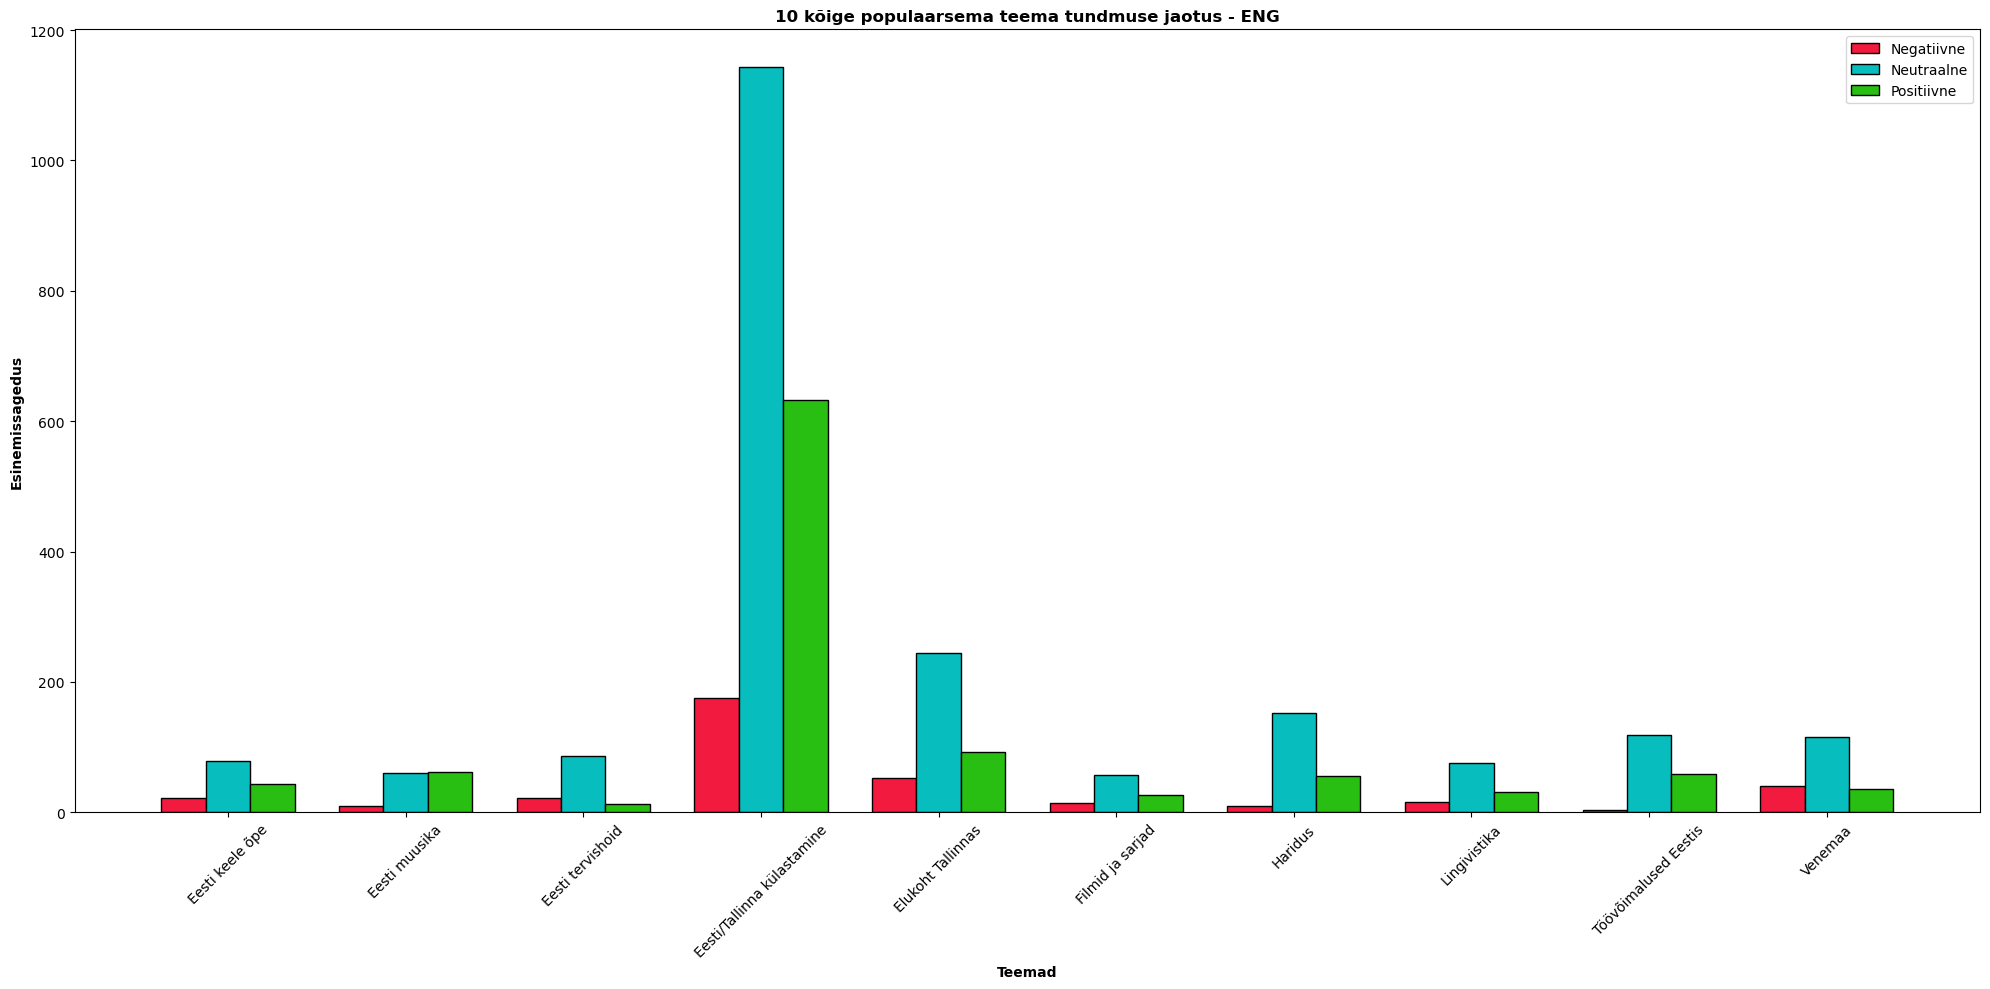

In [204]:
# Group the data by 'topic' column
grouped = frequent_topics_en.groupby('topic_labels')

# Initialize arrays to store counts for each sentiment label
negative_counts = []
neutral_counts = []
positive_counts = []
topics = []

# Iterate over each group
for name, group in grouped:
    topics.append(name)
    # Count the occurrences of each sentiment label in the group
    sentiment_counts = group['sentiment'].value_counts()
    # Append counts to corresponding arrays
    negative_counts.append(sentiment_counts.get('Negatiivne', 0))
    neutral_counts.append(sentiment_counts.get('Neutraalne', 0))
    positive_counts.append(sentiment_counts.get('Positiivne', 0))

# Set the width of the bars
bar_width = 0.25

# Set the positions of the bars on the x-axis
r1 = np.arange(len(topics))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]

# Create the bar chart
plt.figure(figsize=(20, 10))

plt.bar(r1, negative_counts, color='#f21b3f', edgecolor='black', width=bar_width, label='Negatiivne')
plt.bar(r2, neutral_counts, color='#08bdbd', edgecolor='black', width=bar_width, label='Neutraalne')
plt.bar(r3, positive_counts, color='#29bf12', edgecolor='black', width=bar_width, label='Positiivne')

# Add xticks on the middle of the group bars
plt.xlabel('Teemad', fontweight='bold')
plt.xticks([r + bar_width for r in range(len(topics))], topics)

# Add labels and title
plt.ylabel('Esinemissagedus', fontweight='bold')
plt.title('10 kõige populaarsema teema tundmuse jaotus - ENG', fontweight='bold')

# Add legend
plt.legend()

# Show the plot
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('topic_post_en.png')
plt.show()


In [181]:
sent_dict_en = dict()
topic_com_labels_en = dict()

for i in range(len(frequent_topics_en)):
    topic = frequent_topics_en.loc[i].topic_labels
    
    if topic not in sent_dict_en.keys():
        sent_dict_en[topic] = [[frequent_topics_en.loc[i]["sentiment"], frequent_topics_en.loc[i]["comment_sentiment"]]]

        i_topic_list = []
        for j in frequent_topics_en.loc[i]["comment_sentiment"]:
            if isinstance(j, list):
                for k in j:
                    i_topic_list.append(k)
            else:
                i_topic_list.append(j)

        topic_com_labels_en[topic] = i_topic_list

    else:
        sent_dict_en[topic].append([frequent_topics_en.loc[i]["sentiment"], frequent_topics_en.loc[i]["comment_sentiment"]])

        for j in frequent_topics_en.loc[i]["comment_sentiment"]:
            if isinstance(j, list):
                for k in j:
                    topic_com_labels_en[topic].append(k)
            else:
                topic_com_labels_en[topic].append(j)

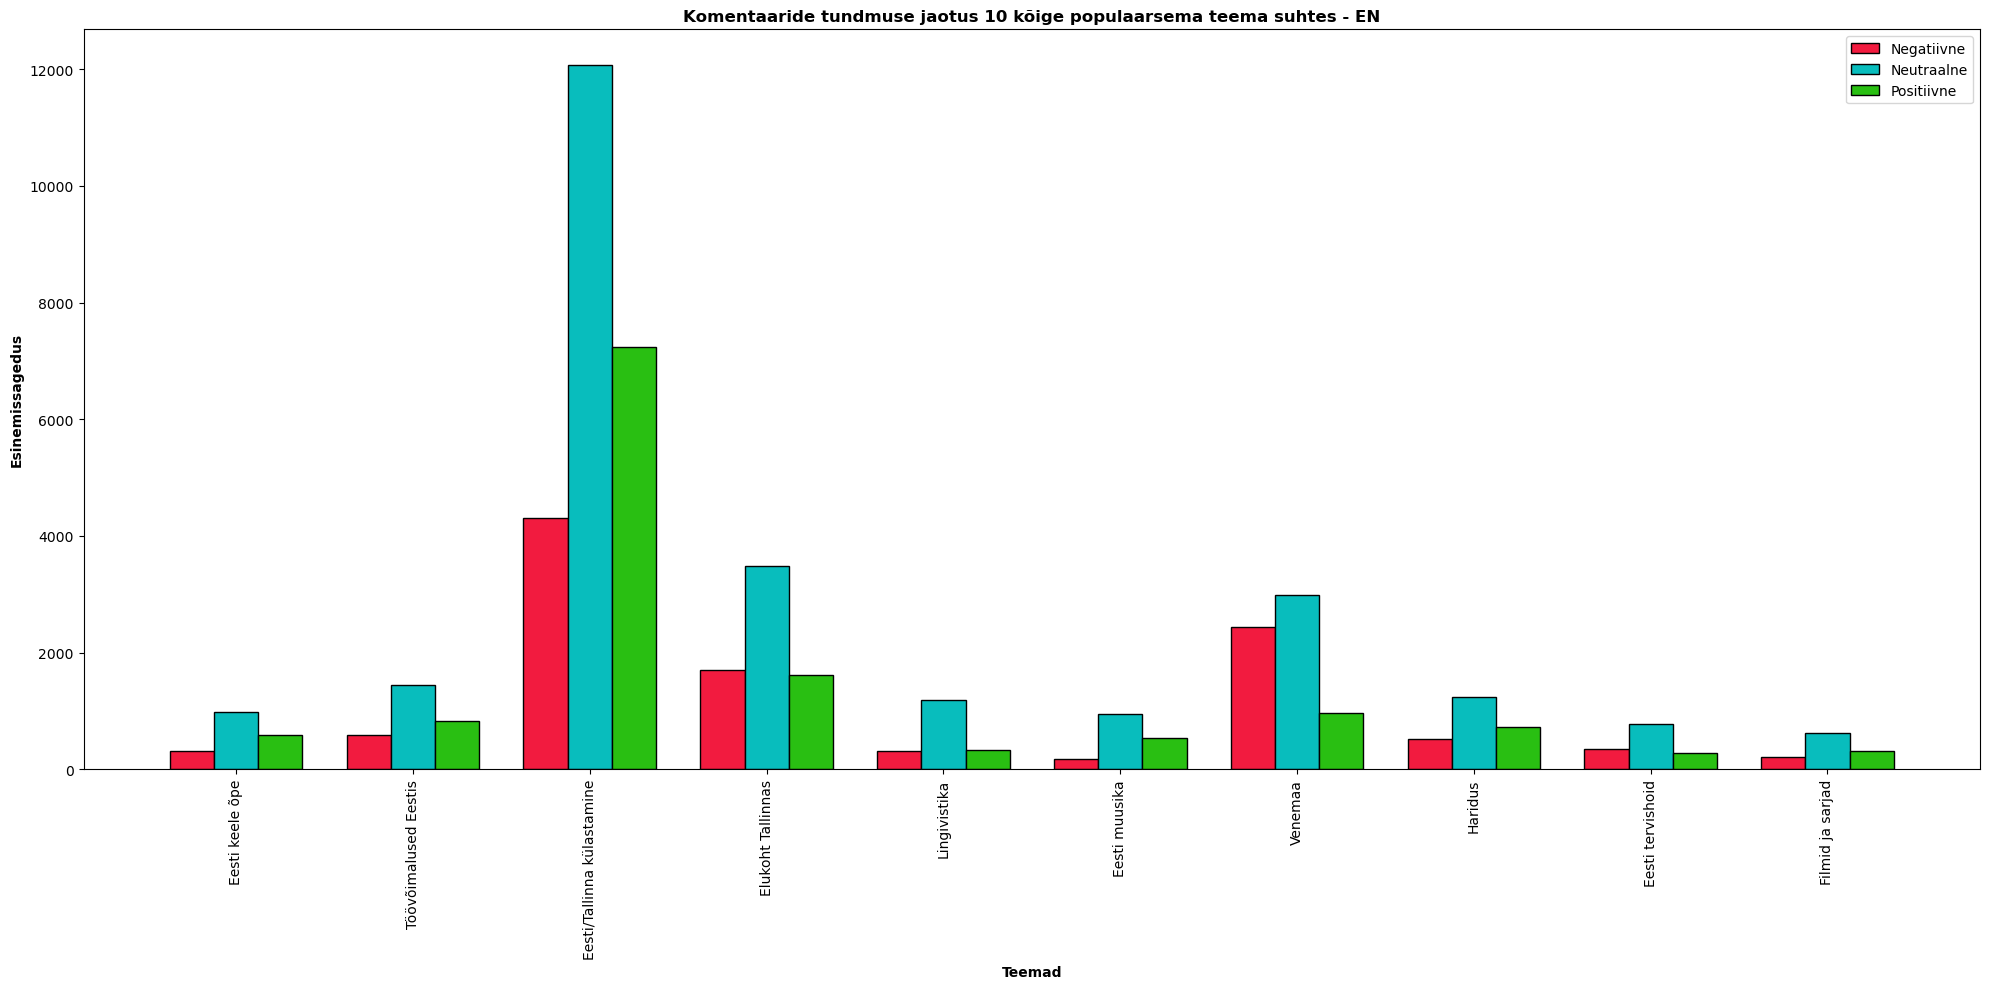

In [183]:
negative_counts = []
neutral_counts = []
positive_counts = []
topics = list(topic_com_labels_en.keys())

for topic in topics:
    sentiment_counts = np.array([topic_com_labels_en[topic].count(label) for label in ['negative', 'neutral', 'positive']])
    negative_counts.append(sentiment_counts[0])
    neutral_counts.append(sentiment_counts[1])
    positive_counts.append(sentiment_counts[2])

bar_width = 0.25

r1 = np.arange(len(topics))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]

plt.figure(figsize=(20, 10))

plt.bar(r1, negative_counts, color='#f21b3f', edgecolor='black', width=bar_width, label='Negatiivne')
plt.bar(r2, neutral_counts, color='#08bdbd', edgecolor='black', width=bar_width, label='Neutraalne')
plt.bar(r3, positive_counts, color='#29bf12', edgecolor='black', width=bar_width, label='Positiivne')

plt.xlabel('Teemad', fontweight='bold')
plt.xticks([r + bar_width for r in range(len(topics))], topics)
plt.ylabel('Esinemissagedus', fontweight='bold')
plt.title('Komentaaride tundmuse jaotus 10 kõige populaarsema teema suhtes - EN', fontweight='bold')
plt.legend()
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig('topic_com_en.png')
plt.show()

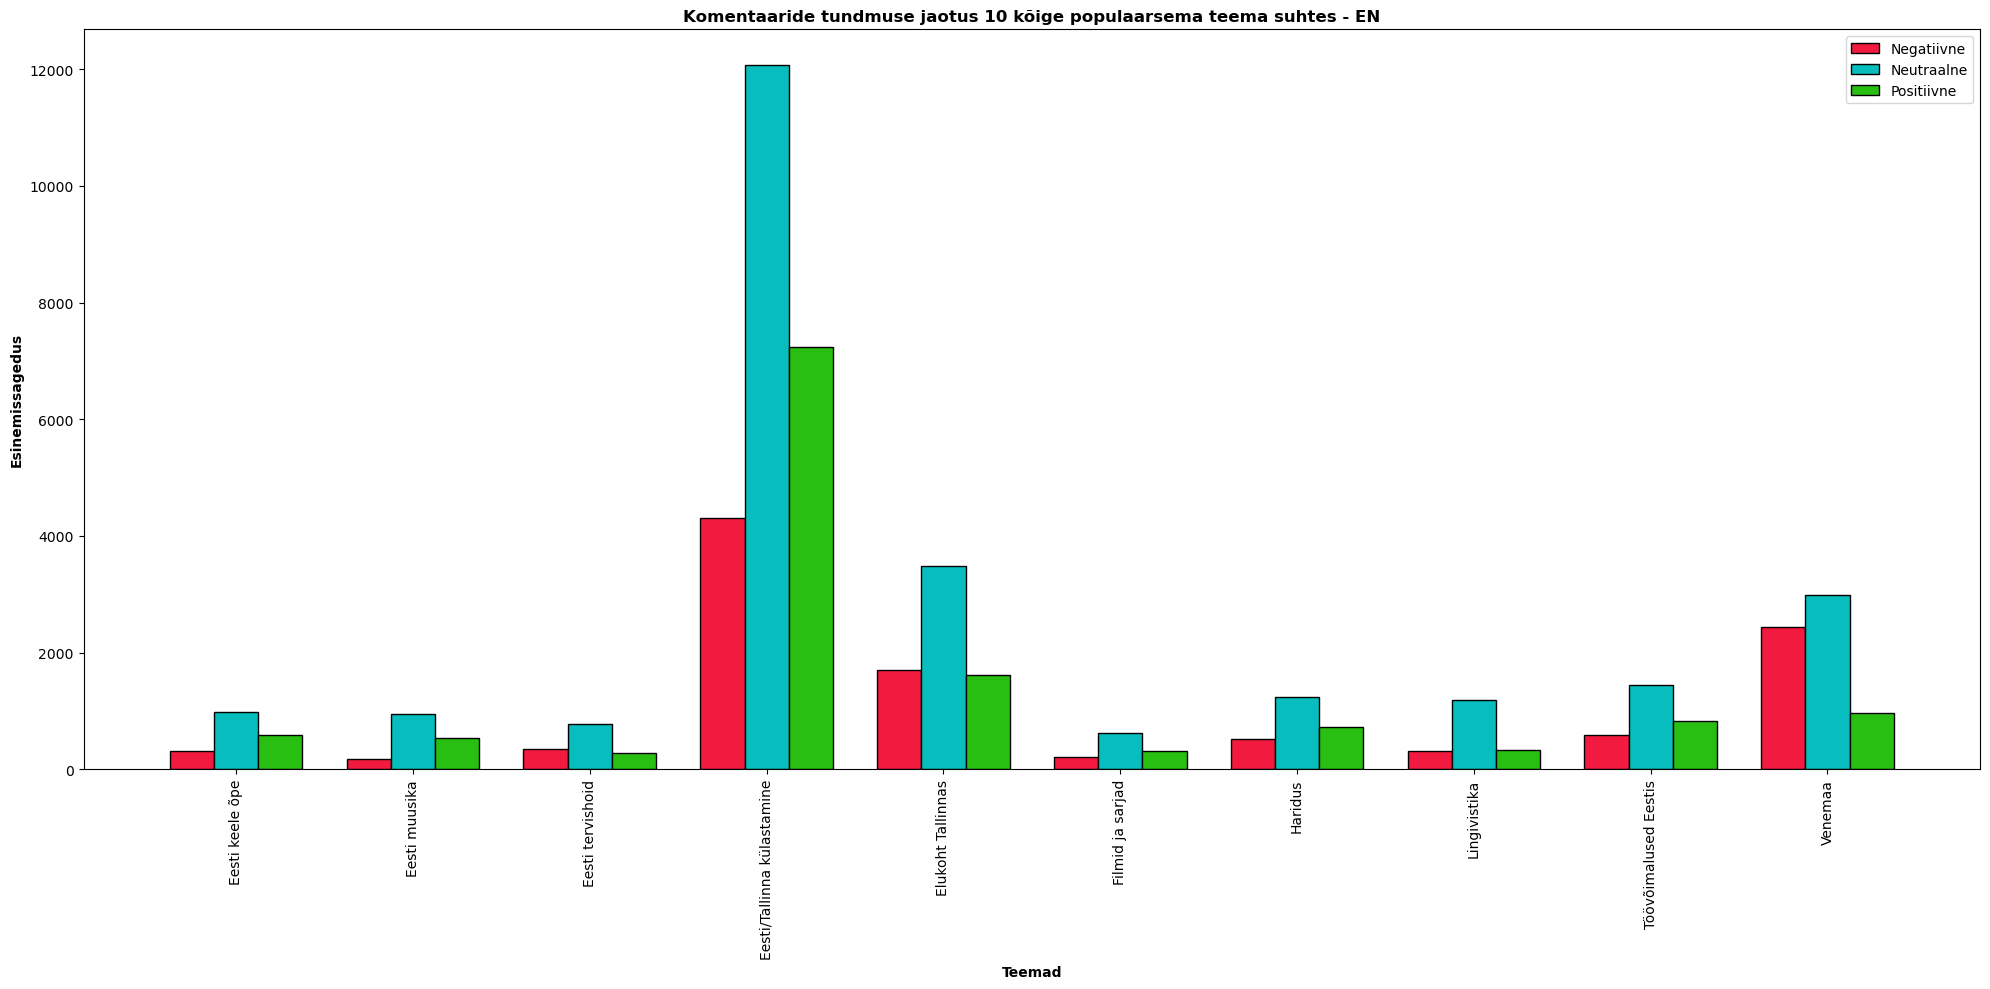

In [207]:
negative_counts = []
neutral_counts = []
positive_counts = []
topics = list(topic_com_labels_en.keys())

# Sort topics alphabetically
topics_sorted = sorted(topics)

for topic in topics_sorted:
    sentiment_counts = np.array([topic_com_labels_en[topic].count(label) for label in ['negative', 'neutral', 'positive']])
    negative_counts.append(sentiment_counts[0])
    neutral_counts.append(sentiment_counts[1])
    positive_counts.append(sentiment_counts[2])

bar_width = 0.25

r1 = np.arange(len(topics_sorted))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]

plt.figure(figsize=(20, 10))

plt.bar(r1, negative_counts, color='#f21b3f', edgecolor='black', width=bar_width, label='Negatiivne')
plt.bar(r2, neutral_counts, color='#08bdbd', edgecolor='black', width=bar_width, label='Neutraalne')
plt.bar(r3, positive_counts, color='#29bf12', edgecolor='black', width=bar_width, label='Positiivne')

plt.xlabel('Teemad', fontweight='bold')
plt.xticks([r + bar_width for r in range(len(topics_sorted))], topics_sorted)
plt.ylabel('Esinemissagedus', fontweight='bold')
plt.title('Komentaaride tundmuse jaotus 10 kõige populaarsema teema suhtes - EN', fontweight='bold')
plt.legend()
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig('topic_com_en.png')
plt.show()


In [313]:
sent_dict = dict()
topic_com_labels_en = dict()

for i in range(len(df_en)):
    topic = df_en.loc[i].topic_labels
    
    if topic not in sent_dict.keys():
        sent_dict[topic] = [[df_en.loc[i]["sentiment"], df_en.loc[i]["comment_sentiment"]]]

        i_topic_list = []
        for j in df_en.loc[i]["comment_sentiment"]:
            if isinstance(j, list):
                for k in j:
                    i_topic_list.append(k)
            else:
                i_topic_list.append(j)

        topic_com_labels_en[topic] = i_topic_list

    else:
        sent_dict[topic].append([df_en.loc[i]["sentiment"], df_en.loc[i]["comment_sentiment"]])

        for j in df_en.loc[i]["comment_sentiment"]:
            
            if isinstance(j, list):
                for k in j:
                    topic_com_labels_en[topic].append(k)
            else:
                topic_com_labels_en[topic].append(j)

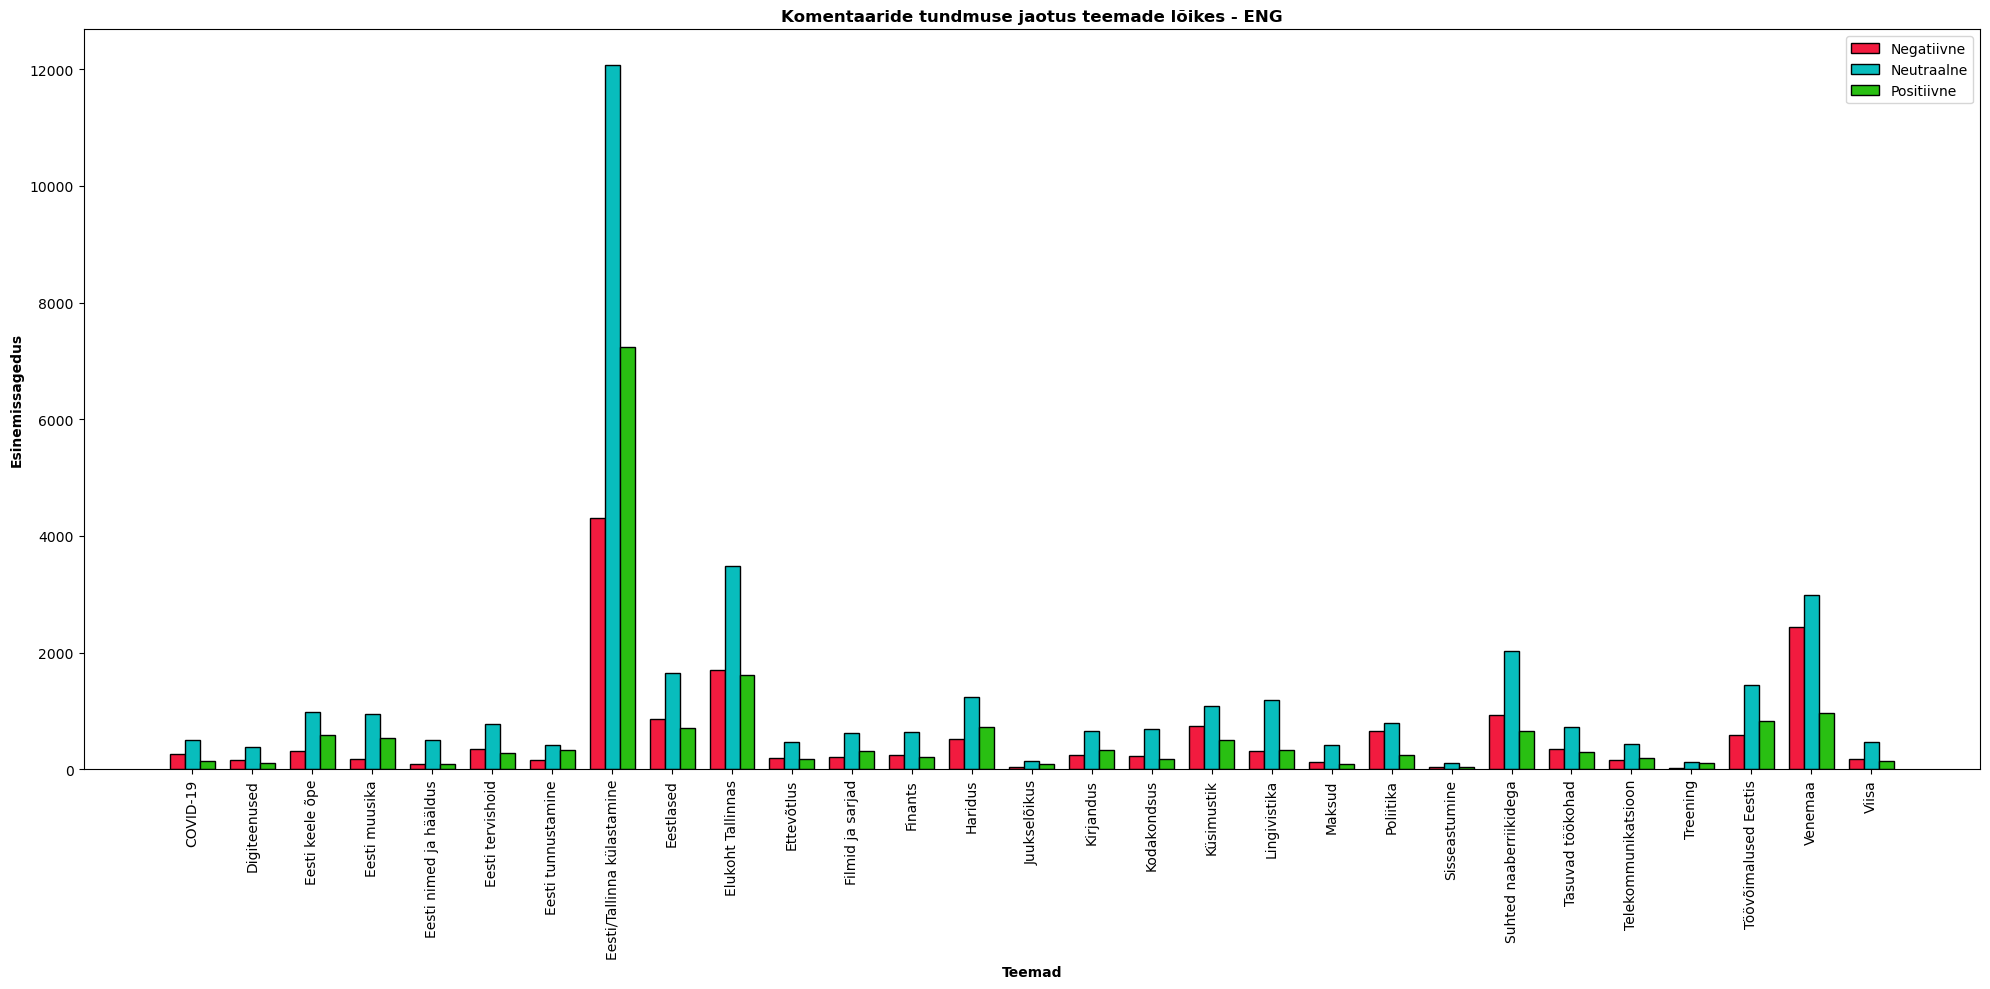

In [316]:
negative_counts = []
neutral_counts = []
positive_counts = []
topics = list(topic_com_labels_en.keys())
topics.sort()

for topic in topics:
    sentiment_counts = np.array([topic_com_labels_en[topic].count(label) for label in ['negative', 'neutral', 'positive']])
    negative_counts.append(sentiment_counts[0])
    neutral_counts.append(sentiment_counts[1])
    positive_counts.append(sentiment_counts[2])

bar_width = 0.25

r1 = np.arange(len(topics))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]

plt.figure(figsize=(20, 10))

plt.bar(r1, negative_counts, color='#f21b3f', edgecolor='black', width=bar_width, label='Negatiivne')
plt.bar(r2, neutral_counts, color='#08bdbd', edgecolor='black', width=bar_width, label='Neutraalne')
plt.bar(r3, positive_counts, color='#29bf12', edgecolor='black', width=bar_width, label='Positiivne')

plt.xlabel('Teemad', fontweight='bold')
plt.xticks([r + bar_width for r in range(len(topics))], topics)
plt.ylabel('Esinemissagedus', fontweight='bold')
plt.title('Komentaaride tundmuse jaotus teemade lõikes - ENG', fontweight='bold')
plt.legend()
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [185]:
df_en.to_csv('topics_n_sents_en_out.csv', index=False) 